In [1]:
%reload_ext autoreload
%autoreload 2
from fastprogress import master_bar, progress_bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from tinyimagenet_models.vgg import *
from utils.dataset import *
from utils.image_utils import *
device = "cuda" if torch.cuda.is_available() else "cpu"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 13

In [2]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params

transform_train = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
])

# Might need a different transform 

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

BATCH_SIZE = 300
EPOCHS = 30

## Load dataset and create dataloader

In [28]:
exp_name = "vgg11_jpeg60"
train_dset = ClassificationDataset("_jpeg_60", "tiny", train = True, transform = transform_train)
test_dset = ClassificationDataset("", "tiny", train = False, transform = transform_test)

train_loader = DataLoader(train_dset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dset, batch_size = BATCH_SIZE, shuffle = False)

## Load Model

In [29]:
net = VGG('VGG11').to(device)
# net = ResNet18().to(device)
print(pytorch_count_params(net))

11689416


## Model Training

In [30]:
def train(trainloader):
    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#     optimizer = optim.Adam(net.parameters(), lr = 0.1)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    accuracy = []
    losses = []
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return correct/total, train_loss/(100000/BATCH_SIZE) 

def test(testloader):
    softmax_output = nn.Softmax()
    criterion = nn.CrossEntropyLoss()
    metrics = []
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    correct_top5 = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            top5_values, top5_ind = torch.topk(outputs, 5, dim = 1)
            f = top5_ind.transpose(0,1) - targets
            zero_elems = torch.numel(f) - torch.count_nonzero(f)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            correct_top5 += zero_elems.item()
        return correct/total, correct_top5/total 

    
RUNS = 1

all_train_acc = []
all_test_acc = []
all_top5_acc = []
max_test_acc = 0
for run in progress_bar(range(RUNS)):
    train_acc, train_loss, test_acc, test_top5 = [], [], [], []
    net = VGG('VGG11').to(device)
    max_test_acc = 0
    for epoch in progress_bar(range(EPOCHS)):    
      train_a, train_l = train(train_loader)
      test_a, test_a5 = test(test_loader)

      if test_a5 > max_test_acc:
        max_test_acc = test_a5 
        model_state = net.state_dict()
        print(test_a, test_a5)

      train_acc.append(train_a)
      train_loss.append(train_l)
      test_acc.append(test_a)
      test_top5.append(test_a5)
    print("Train Accuracy: {}, Test Accuracy: {}".format(train_a, test_a))
    all_train_acc.append(train_acc)
    all_test_acc.append(test_acc)
    all_top5_acc.append(test_top5)

np.savez("exp_results/{}.npz".format(exp_name), train_acc=all_train_acc, train_loss=train_loss, test_acc=all_test_acc, test_top5_acc=all_top5_acc)
torch.save(model_state, "saved_models/{}.pt".format(exp_name))

0.0271 0.1129
0.0748 0.2367
0.1609 0.3981
0.1836 0.4323
0.1967 0.4405
0.2284 0.4841
0.2672 0.5364
0.3058 0.5829
0.3633 0.6343
0.3554 0.6345
0.3711 0.6452
0.3885 0.6536
0.39 0.6585
0.4162 0.6797
Train Accuracy: 0.61338, Test Accuracy: 0.3553


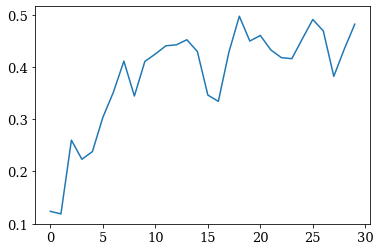

In [13]:
plt.plot(test_top5)

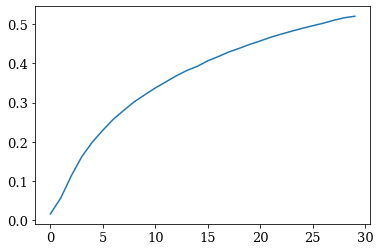

In [11]:
plt.plot(np.mean(all_train_acc, 0))

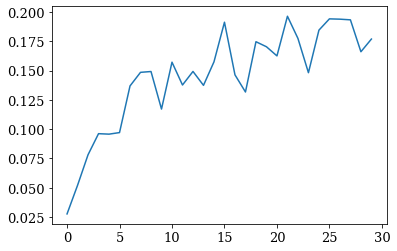

In [12]:
plt.plot(np.mean(all_test_acc, 0))

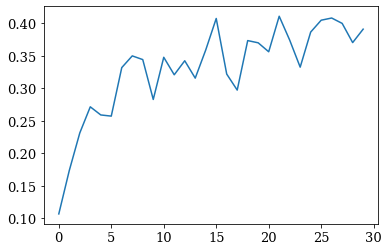

In [13]:
plt.plot(np.mean(all_top5_acc, 0))

In [ ]:
tiny_jpeg_bpp = [1.06, 1.5, 2.38, 3.73, 5.59, 9.29]
tiny_bls_bpp = [0.257, 0.606, 0.859, 1.206, 1.596, 1.744 ]
tiny_full_bls_bpp = [1.364, 2.78, 3.79, 5.182, 6.743, 7.335]